In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import os

plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.grid'] = False

os.makedirs('analysis_results/boxplots_18paths', exist_ok=True)
print("Output directory: analysis_results/boxplots_18paths")

Output directory: analysis_results/boxplots_18paths


In [2]:
def get_mediators():
    return ['cardio28', 'cns28', 'coag28', 'hepatic28', 'icufd', 'orgfree28', 'pulmon28', 'renal28', 'vfd']

def filter_18_paths(df, mediators):
    alcohol_to_mediator = df[(df['treatment'] == 'alcohol_binary') & (df['outcome'].isin(mediators))]
    mediator_to_death = df[(df['treatment'].isin(mediators)) & (df['outcome'] == 'death90')]
    return pd.concat([alcohol_to_mediator, mediator_to_death], ignore_index=True)

def get_file_configurations():
    return [
        ('Access/group4_nondrinker_vs_moderate_first_results.csv', 
         'Access/group1_nondrinker_vs_heavy_first_results.csv', 
         'ND_vs_Moderate', 'ND_vs_Heavy', '1_All_Drinkers'),
        ('Access/cirrhosis_absent_continuous_drinks_per_week_first_results.csv', 
         'Access/cirrhosis_present_continuous_drinks_per_week_first_results.csv',
         'Cirrhosis_Absent', 'Cirrhosis_Present', '2_Cirrhosis_Drinks_Per_Week'),
        ('Access/cirrhosis_absent_group3_nondrinker_vs_anydrinker_first_results.csv', 
         'Access/cirrhosis_present_group3_nondrinker_vs_anydrinker_first_results.csv',
         'CirrAbsent_ND_vs_Any', 'CirrPresent_ND_vs_Any', '3_Cirrhosis_ND_vs_Any'),
        ('Access/cirrhosis_absent_group4_nondrinker_vs_moderate_first_results.csv', 
         'Access/cirrhosis_present_group4_nondrinker_vs_moderate_first_results.csv',
         'CirrAbsent_ND_vs_Mod', 'CirrPresent_ND_vs_Mod', '4_Cirrhosis_ND_vs_MD'),
        ('Access/cirrhosis_absent_group1_nondrinker_vs_heavy_first_results.csv', 
         'Access/cirrhosis_present_group1_nondrinker_vs_heavy_first_results.csv',
         'CirrAbsent_ND_vs_Heavy', 'CirrPresent_ND_vs_Heavy', '5_Cirrhosis_ND_vs_HD'),
        ('Access/gender_male_continuous_drinks_per_week_first_results.csv', 
         'Access/gender_female_continuous_drinks_per_week_first_results.csv',
         'Male_Drinks_Per_Week', 'Female_Drinks_Per_Week', '6_Gender_Drinks_Per_Week'),
        ('Access/gender_male_group1_nondrinker_vs_heavy_first_results.csv', 
         'Access/gender_female_group1_nondrinker_vs_heavy_first_results.csv',
         'Male_ND_vs_Heavy', 'Female_ND_vs_Heavy', '7_Gender_ND_vs_HD'),
        ('Access/gender_male_group3_nondrinker_vs_anydrinker_first_results.csv', 
         'Access/gender_female_group3_nondrinker_vs_anydrinker_first_results.csv',
         'Male_ND_vs_Any', 'Female_ND_vs_Any', '8_Gender_ND_vs_Any'),
        ('Access/gender_male_group4_nondrinker_vs_moderate_first_results.csv', 
         'Access/gender_female_group4_nondrinker_vs_moderate_first_results.csv',
         'Male_ND_vs_Mod', 'Female_ND_vs_Mod', '9_Gender_ND_vs_MD')
    ]

def get_comparison_labels():
    return {
        '1_All_Drinkers': 'All Drinkers\nND vs MD & HD',
        '2_Cirrhosis_Drinks_Per_Week': 'Cirrhosis\nDrinks/Week',
        '3_Cirrhosis_ND_vs_Any': 'Cirrhosis\nND vs Any',
        '4_Cirrhosis_ND_vs_MD': 'Cirrhosis\nND vs MD',
        '5_Cirrhosis_ND_vs_HD': 'Cirrhosis\nND vs HD',
        '6_Gender_Drinks_Per_Week': 'Gender\nDrinks/Week',
        '7_Gender_ND_vs_HD': 'Gender\nND vs HD',
        '8_Gender_ND_vs_Any': 'Gender\nND vs Any',
        '9_Gender_ND_vs_MD': 'Gender\nND vs MD'
    }

mediators = get_mediators()
files_config = get_file_configurations()
comparison_map = get_comparison_labels()
print(f"Mediators: {len(mediators)}")
print(f"Loaded {len(files_config)} comparisons")

Mediators: 9
Loaded 9 comparisons


In [3]:
def create_combined_boxplot_18paths(indices, files_config, comparison_map, mediators, title, filename, output_dir):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
    all_data = []
    all_y_values = []
    
    # First pass: collect all data and find global y-range
    plot_data = []
    for plot_idx, comp_idx in enumerate(indices):
        file1, file2, g1_name, g2_name, comp_key = files_config[comp_idx]
        
        df1 = pd.read_csv(file1)
        df2 = pd.read_csv(file2)
        
        df1_filtered = filter_18_paths(df1, mediators)
        df2_filtered = filter_18_paths(df2, mediators)
        
        group1_effects = df1_filtered['effect'].dropna().values
        group2_effects = df2_filtered['effect'].dropna().values
        
        all_y_values.extend(group1_effects)
        all_y_values.extend(group2_effects)
        
        plot_data.append({
            'group1_effects': group1_effects,
            'group2_effects': group2_effects,
            'g1_name': g1_name,
            'g2_name': g2_name,
            'comp_key': comp_key
        })
    
    # Calculate global y-range
    global_ymin = min(all_y_values)
    global_ymax = max(all_y_values)
    y_range = global_ymax - global_ymin
    y_margin = y_range * 0.1
    
    # Second pass: create plots with identical y-axis
    for plot_idx, data in enumerate(plot_data):
        ax = axes[plot_idx]
        ax.set_facecolor('white')
        
        group1_effects = data['group1_effects']
        group2_effects = data['group2_effects']
        g1_name = data['g1_name']
        g2_name = data['g2_name']
        comp_name = comparison_map[data['comp_key']]
        
        positions = [1, 2]
        
        # Determine if this is cirrhosis or gender comparison
        is_cirrhosis = 'Cirr' in g1_name
        
        # Color scheme: Cirrhosis (Absent=lightblue, Present=lightcoral) or Gender (Male=lightblue, Female=pink)
        if is_cirrhosis:
            color1 = 'lightblue'
            color2 = 'lightcoral'
        else:
            color1 = 'lightblue' if 'Male' in g1_name else 'pink'
            color2 = 'pink' if 'Female' in g2_name else 'lightblue'
        
        bp = ax.boxplot([group1_effects, group2_effects], positions=positions, widths=0.5,
                        patch_artist=True, showmeans=True, meanline=True,
                        boxprops=dict(edgecolor='black', linewidth=2, facecolor='white'),
                        medianprops=dict(color='red', linewidth=2.5),
                        meanprops=dict(color='blue', linewidth=2, linestyle='--'),
                        whiskerprops=dict(linewidth=2, color='black'),
                        capprops=dict(linewidth=2, color='black'))
        
        # Color the boxes
        bp['boxes'][0].set_facecolor(color1)
        bp['boxes'][0].set_alpha(0.6)
        bp['boxes'][1].set_facecolor(color2)
        bp['boxes'][1].set_alpha(0.6)
        
        # Different empty symbols for each group
        markers1 = ['o', '^', 's']
        markers2 = ['D', 'v', 'p']
        
        # Plot group 1 with rotating symbols
        for i, effect in enumerate(group1_effects):
            marker = markers1[i % len(markers1)]
            ax.scatter(1 + np.random.normal(0, 0.04), effect, 
                      marker=marker, s=50, edgecolors=color1.replace('light', 'dark'), 
                      facecolors='none', linewidths=1.5, zorder=3)
        
        # Plot group 2 with rotating symbols
        for i, effect in enumerate(group2_effects):
            marker = markers2[i % len(markers2)]
            ax.scatter(2 + np.random.normal(0, 0.04), effect, 
                      marker=marker, s=50, edgecolors=color2.replace('light', '').replace('coral', 'red').replace('pink', 'deeppink'), 
                      facecolors='none', linewidths=1.5, zorder=3)
        
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
        ax.set_xticks(positions)
        label1 = g1_name.replace('_', ' ')[:25]
        label2 = g2_name.replace('_', ' ')[:25]
        ax.set_xticklabels([label1, label2], fontsize=10)
        ax.set_ylabel('Effect Size', fontsize=12, fontweight='bold')
        ax.set_title(comp_name, fontsize=13, fontweight='bold', pad=10)
        
        # Set identical y-axis range for all subplots
        ax.set_ylim(global_ymin - y_margin, global_ymax + y_margin)
        
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)
        
        y_pos = ax.get_ylim()[0] + 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])
        ax.text(1, y_pos, f'n={len(group1_effects)}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
        ax.text(2, y_pos, f'n={len(group2_effects)}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
        
        if len(group1_effects) > 0 and len(group2_effects) > 0:
            stat, pval = stats.mannwhitneyu(group1_effects, group2_effects, alternative='two-sided')
            sig_text = f'p={pval:.4f}' + (' *' if pval < 0.05 else '')
            ax.text(0.5, 0.98, sig_text, transform=ax.transAxes, ha='center', va='top', 
                   fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
        
        for effect in group1_effects:
            all_data.append({'Comparison': comp_name, 'Group': g1_name, 'Effect': effect})
        for effect in group2_effects:
            all_data.append({'Comparison': comp_name, 'Group': g2_name, 'Effect': effect})
    
    legend_elements = [
        Line2D([0], [0], color='red', linewidth=2.5, label='Median'),
        Line2D([0], [0], color='blue', linewidth=2, linestyle='--', label='Mean'),
        Patch(facecolor='white', edgecolor='black', linewidth=2, label='Box: IQR (25th-75th percentile)'),
        Line2D([0], [0], color='black', linewidth=2, label='Whiskers: 1.5 × IQR'),
        Line2D([0], [0], marker='o', color='w', markeredgecolor='black', markersize=8, 
               markeredgewidth=1.5, label='Empty symbols: Individual data points')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=5, 
               bbox_to_anchor=(0.5, -0.1), fontsize=10, frameon=True, edgecolor='black', framealpha=1)
    
    plt.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{filename}.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(f'{output_dir}/{filename}.pdf', bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"Saved: {filename}.png/pdf")
    
    df_data = pd.DataFrame(all_data)
    df_data.to_csv(f'{output_dir}/{filename}_data.csv', index=False)
    print(f"Saved: {filename}_data.csv (Total: {len(df_data)} data points)")
    print(f"Y-axis range: {global_ymin:.3f} to {global_ymax:.3f} (identical across all 3 plots)")
    
    return df_data

print("Function defined")

Function defined



CIRRHOSIS COMPARISONS (18 PATHS)


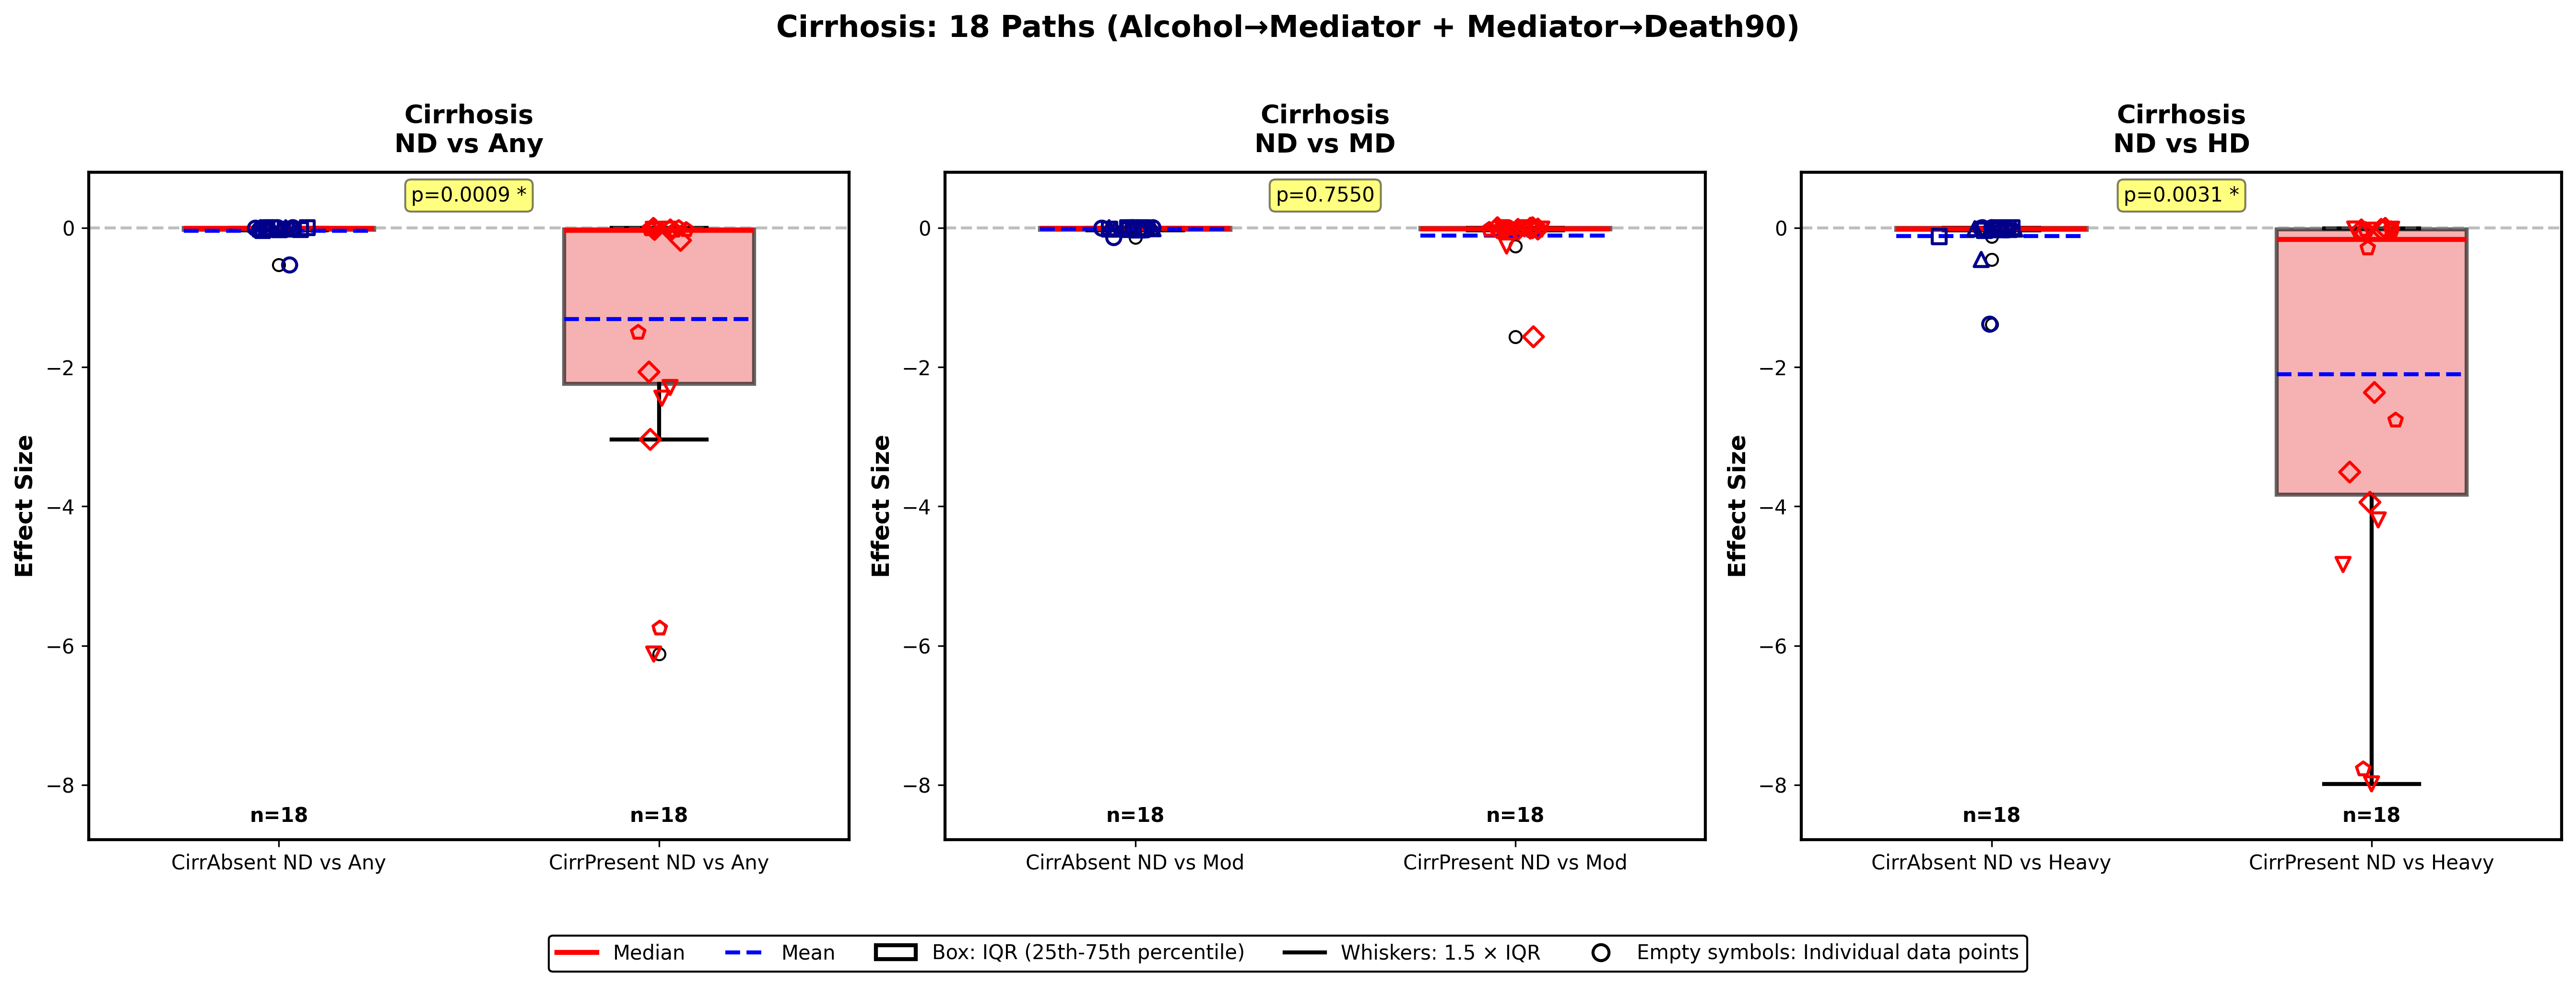

Saved: cirrhosis_18paths.png/pdf
Saved: cirrhosis_18paths_data.csv (Total: 108 data points)
Y-axis range: -7.984 to -0.000 (identical across all 3 plots)


In [4]:
output_dir = 'analysis_results/boxplots_18paths'

print("\n" + "="*60)
print("CIRRHOSIS COMPARISONS (18 PATHS)")
print("="*60)

cirrhosis_data = create_combined_boxplot_18paths(
    indices=[2, 3, 4],
    files_config=files_config,
    comparison_map=comparison_map,
    mediators=mediators,
    title='Cirrhosis: 18 Paths (Alcohol→Mediator + Mediator→Death90)',
    filename='cirrhosis_18paths',
    output_dir=output_dir
)


GENDER COMPARISONS (18 PATHS)


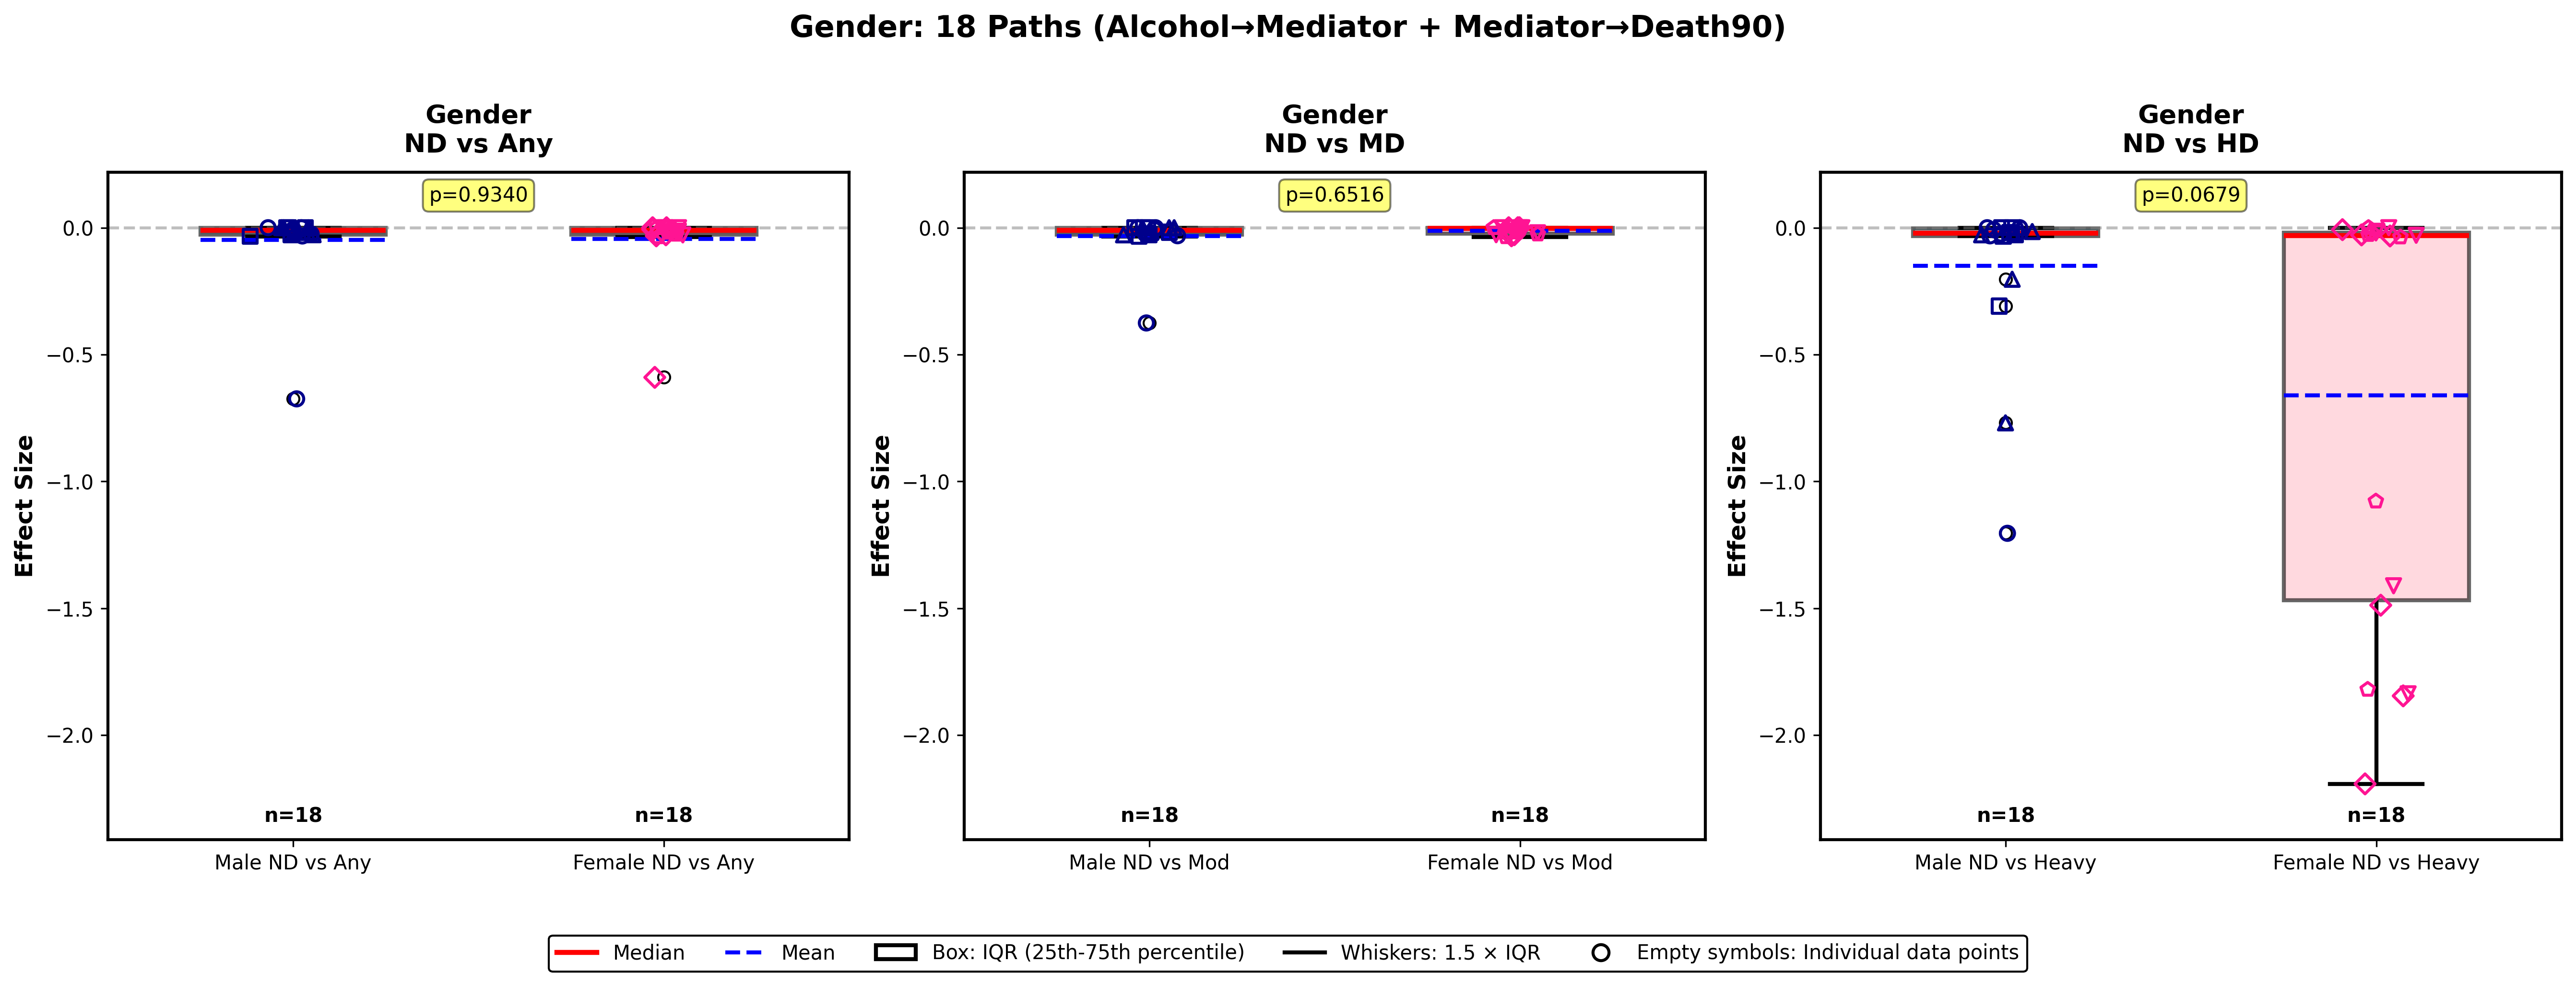

Saved: gender_18paths.png/pdf
Saved: gender_18paths_data.csv (Total: 108 data points)
Y-axis range: -2.192 to -0.000 (identical across all 3 plots)


In [5]:
print("\n" + "="*60)
print("GENDER COMPARISONS (18 PATHS)")
print("="*60)

gender_data = create_combined_boxplot_18paths(
    indices=[7, 8, 6],
    files_config=files_config,
    comparison_map=comparison_map,
    mediators=mediators,
    title='Gender: 18 Paths (Alcohol→Mediator + Mediator→Death90)',
    filename='gender_18paths',
    output_dir=output_dir
)

In [6]:
print("\n" + "="*60)
print("18-PATH BOXPLOTS COMPLETE")
print("="*60)
print("\nGenerated:")
print("  1. cirrhosis_18paths.png/pdf - Comparisons 3, 4, 5")
print("  2. gender_18paths.png/pdf - Comparisons 8, 9, 7")
print("\nFeatures:")
print("  - Only 18 paths: alcohol_binary→mediator (9) + mediator→death90 (9)")
print("  - NO gray gridlines (removed)")
print("  - Dark borders on boxes and axes")
print("  - All individual data points shown")
print("  - Figure legend included")
print("  - Data files attached (_data.csv)")
print("="*60)


18-PATH BOXPLOTS COMPLETE

Generated:
  1. cirrhosis_18paths.png/pdf - Comparisons 3, 4, 5
  2. gender_18paths.png/pdf - Comparisons 8, 9, 7

Features:
  - Only 18 paths: alcohol_binary→mediator (9) + mediator→death90 (9)
  - NO gray gridlines (removed)
  - Dark borders on boxes and axes
  - All individual data points shown
  - Figure legend included
  - Data files attached (_data.csv)
